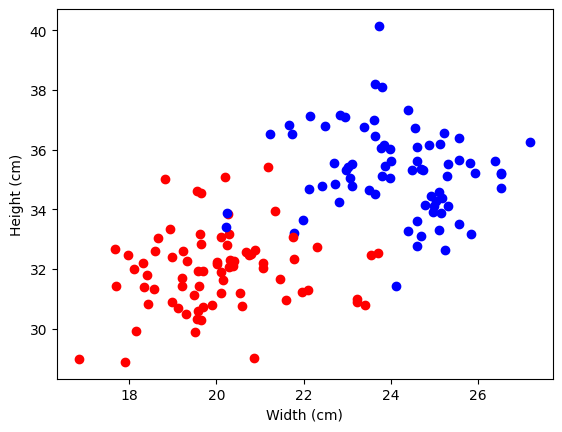

End.


In [3]:
import matplotlib.pyplot as plt
#from matplotlib.lines import Line2D

def read_measurements():
    '''Returns a list with an item for each pokemon measured. 
    Each item is a dictionary with keys "width", "height" & "label".'''
    # each item will contain data about a pokemon
    measurements = []

    data_points_path = "./datapoints.txt"

    with open(data_points_path) as file:
        lines = file.readlines()

    # Manage file contents outside with statement above in order to 
    # close the file asap.

    # remove "\n" at end of each line:
    lines = [line.rstrip() for line in lines]
    # remove first line (header):
    lines = lines[1:]

    # interpret data in each line as a measurement
    for line in lines:
        line_data = line.split(", ")
        width = float(line_data[0])
        height = float(line_data[1])
        label = int(line_data[2])
        measurement = {
            "width": width,
            "height": height,
            "label": label
        }
        measurements.append(measurement)
        #print(f"{measurement = }")
    return measurements

def plot_measurements(measurements):
    for measurement in measurements:
        # if measured pokemon is a pichu:
        if measurement["label"] == 0:
            point_color = "red"
        else:
            point_color = "blue"
        #x = [measurement["width"]]
        #y = [measurement["height"]]
        #l = measurement["label"]
        plt.scatter(
            x = measurement["width"],
            y = measurement["height"],
            c = point_color,
            #label = measurement["label"]
        )
        #plt.plot(x, y, "ro", ms = 5, color=point_color)

    # Explain axiv values with labels:
    plt.xlabel("Width (cm)")
    plt.ylabel("Height (cm)")

    legend_elements = [Line2D([0], [0], marker="o", label="Pichu", 
                              markerfacecolor='red', markersize=10),
                        Line2D([], [], marker=".", label="Pikachu", 
                              markerfacecolor='blue', markersize=10)      
                        ]
    #plt.legend(handles=legend_elements)
    #plt.legend()

    plt.show()

measurements = read_measurements()
plot_measurements(measurements)
#print(f"{len(measurements)} pokemons have been measured.")

print("End.")